In [1]:
import cv2, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# check for image overlaps in two classes
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

def preprocess(im, size, blur, gray=True):
#     im = cv2.GaussianBlur(im, (blur, blur),0)
    if gray:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    else:
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = cv2.resize(im,(size, size))
    return im

In [3]:
# Set VM data path and read labels file

dataPath = '/scratch/data/images/'
df_ind = pd.read_csv('../../../data/processed/test-train/train.csv')
df_ind.head()

,index,filename,label1,label2,label3
0,1,Pia1.2016-10-04.1801+N292_hc.tif,zooplankton,noncopepod,annelida_polychaeta
1,2,Pia1.2016-10-05.1229+N28_hc.tif,zooplankton,noncopepod,annelida_polychaeta
2,3,Pia1.2016-10-06.2118+N136_hc.tif,zooplankton,noncopepod,annelida_polychaeta
3,4,Pia1.2017-03-21.1136+N01644266_hc.tif,zooplankton,noncopepod,annelida_polychaeta
4,5,Pia1.2017-03-21.1136+N01646706_hc.tif,zooplankton,noncopepod,annelida_polychaeta


# Sample Images to Augment

In [4]:
df_ind['label2'].value_counts()

detritus      36000
copepod        9253
noncopepod     6056
Name: label2, dtype: int64

In [5]:
cop_im_list = df_ind[df_ind['label2']=='copepod']['filename'].tolist()
noncop_im_list = df_ind[df_ind['label2']=='noncopepod']['filename'].tolist()

print(len(cop_im_list), len(noncop_im_list))
print(intersection(cop_im_list, noncop_im_list))

9253 6056
[]


In [6]:
savePath = '/shared/jenniferding/plankton_c/all_cop/all_cop/'
augmentPath = savePath + "augment/"

n = len(cop_im_list)

for i in sorted(cop_im_list)[:n]:
    im = cv2.imread(dataPath + i)
    im = preprocess(im, 64, 3, gray=True)
    savename = i.replace('.tif', '.png')
    cv2.imwrite(savePath+savename, im)
    
print(len(os.listdir(savePath)))

9254


# GANS

In [7]:
# Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

In [8]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [9]:
dataset = keras.preprocessing.image_dataset_from_directory(
    "/shared/jenniferding/plankton_c/all_cop/", label_mode=None, image_size=(64,64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0) 

Found 9253 files belonging to 1 classes.


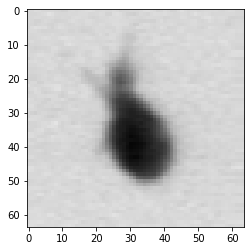

In [11]:
for x in dataset:
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [12]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64,64,3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        3136      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       131200    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         262272    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)            

In [13]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 16, 128)       262272    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       524544    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 32, 32, 256)       0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 512)       20

In [14]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [15]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(augmentPath+"generated_img_%03d_%d.png" % (epoch, i))


In [18]:
epochs = 50  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=5, latent_dim=latent_dim)]
)


Epoch 1/50
290/290 [==============================] - 1286s 4s/step - d_loss: 0.6924 - g_loss: 1.0399
Epoch 2/50
290/290 [==============================] - 1276s 4s/step - d_loss: 0.5920 - g_loss: 1.1322
Epoch 3/50
290/290 [==============================] - 1306s 4s/step - d_loss: 0.6420 - g_loss: 1.0041
Epoch 4/50
290/290 [==============================] - 1282s 4s/step - d_loss: 0.5844 - g_loss: 1.2805
Epoch 5/50
290/290 [==============================] - 1299s 4s/step - d_loss: 0.6442 - g_loss: 0.9805
Epoch 6/50
290/290 [==============================] - 1297s 4s/step - d_loss: 0.6842 - g_loss: 1.4341
Epoch 7/50
290/290 [==============================] - 1302s 4s/step - d_loss: 0.5824 - g_loss: 1.4492
Epoch 8/50
290/290 [==============================] - 1301s 4s/step - d_loss: 0.7683 - g_loss: 0.8417
Epoch 9/50
290/290 [==============================] - 1264s 4s/step - d_loss: 0.6757 - g_loss: 0.9589
Epoch 10/50
290/290 [==============================] - 1265s 4s/step - d_loss: 0.7